# Data Analysis for Observed Data and Synthetic Data

This program serves to take some statistics of the observed data and the synthetic data created by getForcingFunctions, mainly for comparison.

### Observational Data Analysis

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr 
import glob 
import scipy.stats as sts

from getStats import getRemoveDefects, getPrecipEventMeansXARRAY_1D, getAutocorrelationTrunc

In [2]:
def getDailyMeanMaxStdSkewArrays(filelist, keyword):
    
    N_files = len(filelist)
            
    daily_mean_array = [] # the mean of each day's radiation
    daily_max_array = [] # the maximum value of the each day's radiation
    daily_std_array = [] # the standard deviation of each day's diurnal cycle
    daily_skew_array = [] # the skewness of each day's diurnal cycle
    
    for i in range(0, N_files):
        
        #print(i)
        
        tmp_ds = xr.open_dataset(filelist[i])
        
        tmp_rad_data = tmp_ds[keyword].values
        
        N_days = int(tmp_rad_data.shape[0] * (60*24)**(-1))
        
        tmp_rad = np.zeros(N_days*60*24)
        
        if keyword == "F_solar":
            
            for k in range(0, tmp_rad_data.shape[0]):
                tmp_rad[k] = tmp_rad_data[k][0]
        
        else:
            tmp_rad = tmp_rad_data
        
        #print(tmp_rad)
        
        N_days = int(len(tmp_rad) * (60*24)**(-1))
        
        #print(N_days)
        
        tmp_rad_daysplit = np.split(tmp_rad, N_days)
        
        for j in range(0, N_days):
            
            if keyword == "BestEstimate_down_short_hemisp":
                tmp_rad_day_clean = getRemoveDefects(tmp_rad_daysplit[j]) # day's worth of clean data from obs
            
            else:
                tmp_rad_day_clean = tmp_rad_daysplit[j]
            
            if len(tmp_rad_day_clean) > 0: # if getRemoveDefects didn't remove every data point, do:
                daily_mean_array.append(np.mean(tmp_rad_day_clean, axis=0))
                daily_max_array.append(np.amax(tmp_rad_day_clean, axis=0))
                daily_std_array.append(np.std(tmp_rad_day_clean, axis=0))
                daily_skew_array.append(sts.skew(tmp_rad_day_clean, axis=0))
                
            else: # if getRemoveDefects found an entire day's worth of bad data, skip that day and continue looping
                continue
        
    return daily_mean_array, daily_max_array, daily_std_array, daily_skew_array

In [3]:
PATH = "/data/keeling/a/adammb4/SGP_proj_2021/DATA/"
rad_data_filenames = glob.glob(PATH+"SGP_Best*")
obs_keyword = "BestEstimate_down_short_hemisp"

obs_daily_mean_array, obs_daily_max_array, obs_daily_std_array, obs_daily_skew_array = getDailyMeanMaxStdSkewArrays(rad_data_filenames, obs_keyword)

In [11]:
obs_overall_avg_rad = np.mean(obs_daily_mean_array)
obs_peak_daily_rad = np.amax(obs_daily_max_array)
obs_min_daily_rad = np.amin(obs_daily_max_array)
obs_overall_avg_std = np.mean(obs_daily_std_array)
obs_overall_avg_skew = np.mean(obs_daily_skew_array)

print(obs_overall_avg_rad, obs_peak_daily_rad, obs_min_daily_rad, obs_overall_avg_std, sts.skew(obs_daily_mean_array))

423.4194 1290.0751 148.78174 323.9628 -0.9801821708679199


In [5]:
synth_filenames = glob.glob(PATH+"SGP_synth*")
syn_keyword = "F_solar"

syn_daily_mean_array, syn_daily_max_array, syn_daily_std_array, syn_daily_skew_array = getDailyMeanMaxStdSkewArrays(synth_filenames, syn_keyword)

In [12]:
syn_overall_avg_rad = np.mean(syn_daily_mean_array)
syn_peak_daily_rad = np.amax(syn_daily_max_array)
syn_min_daily_rad = np.amin(syn_daily_max_array)
syn_overall_avg_std = np.mean(syn_daily_std_array)
syn_overall_avg_skew = np.mean(syn_daily_skew_array)

print(syn_overall_avg_rad, syn_peak_daily_rad, syn_min_daily_rad, syn_overall_avg_std, sts.skew(syn_daily_mean_array))

179.47772909477175 1163.8175048828125 0.0 184.71099540208556 0.4902259323983497


0.49999988 0.4999999999999998


(0.0, 10.0)

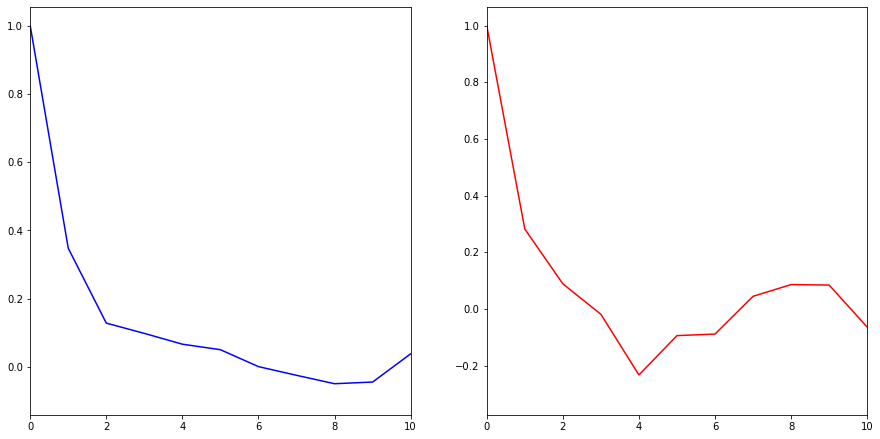

In [7]:
# compute autocorrelation between daily means

obs_auto = getAutocorrelationTrunc(np.std(obs_daily_mean_array)**(-1) * (obs_daily_mean_array - np.mean(obs_daily_mean_array)) )
syn_auto = getAutocorrelationTrunc(np.std(syn_daily_mean_array)**(-1) * (syn_daily_mean_array - np.mean(syn_daily_mean_array)) )

#obs_auto = np.correlate(obs_daily_mean_array,obs_daily_mean_array,mode='full') # t \in (-infty, infty)
#syn_auto = np.correlate(syn_daily_mean_array,syn_daily_mean_array,mode='full') # t \in (-infty, infty)

avg_obs_auto = np.mean(obs_auto)
avg_syn_auto = np.mean(syn_auto)

print(avg_obs_auto, avg_syn_auto)

fig, ax = plt.subplots(1,2, figsize=(15,7.5))

ax[0].plot(obs_auto * (len(obs_daily_mean_array))**(-1), color='blue', label="observation")
ax[0].set_xlim((0,10))

ax[1].plot(syn_auto * (len(syn_daily_mean_array))**(-1), color='red', label="synthetic")
ax[1].set_xlim((0,10))

Text(0, 0.5, 'Frequency')

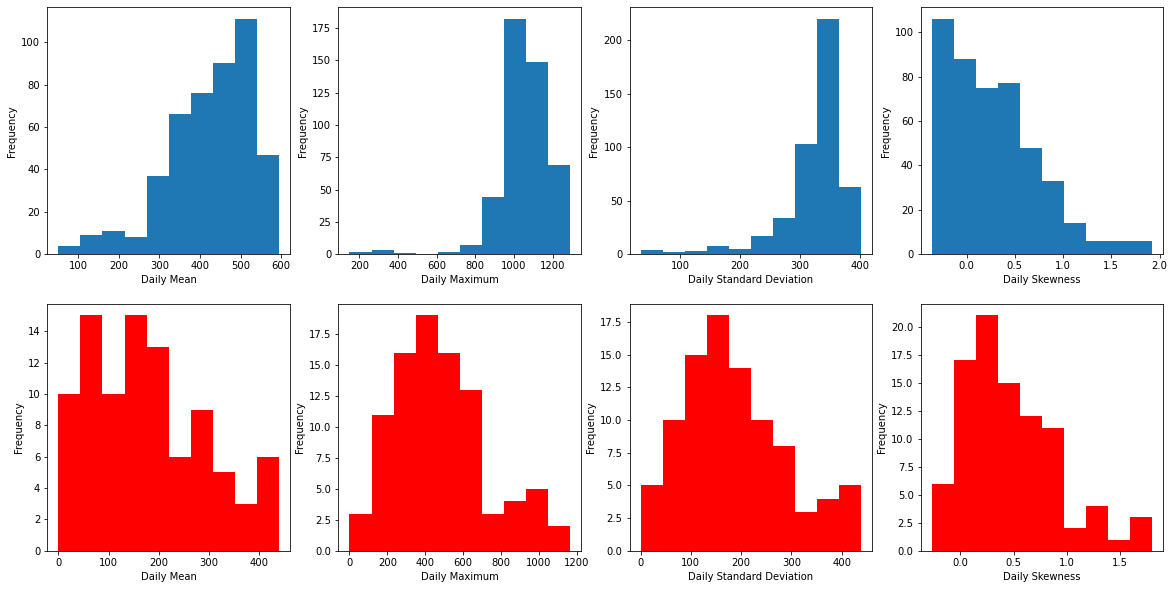

In [10]:
fig, ax = plt.subplots(2,4, figsize=(20,10))

ax[0,0].hist(obs_daily_mean_array)
ax[0,0].set_xlabel("Daily Mean")
ax[0,0].set_ylabel("Frequency")

ax[0,1].hist(obs_daily_max_array)
ax[0,1].set_xlabel("Daily Maximum")
ax[0,1].set_ylabel("Frequency")

ax[0,2].hist(obs_daily_std_array)
ax[0,2].set_xlabel("Daily Standard Deviation")
ax[0,2].set_ylabel("Frequency")

ax[0,3].hist(obs_daily_skew_array)
ax[0,3].set_xlabel("Daily Skewness")
ax[0,3].set_ylabel("Frequency")

ax[1,0].hist(syn_daily_mean_array, color='red')
ax[1,0].set_xlabel("Daily Mean")
ax[1,0].set_ylabel("Frequency")

ax[1,1].hist(syn_daily_max_array, color='red')
ax[1,1].set_xlabel("Daily Maximum")
ax[1,1].set_ylabel("Frequency")

ax[1,2].hist(syn_daily_std_array, color='red')
ax[1,2].set_xlabel("Daily Standard Deviation")
ax[1,2].set_ylabel("Frequency")

ax[1,3].hist(syn_daily_skew_array, color='red')
ax[1,3].set_xlabel("Daily Skewness")
ax[1,3].set_ylabel("Frequency")

In [14]:
obs_precip_filenames = glob.glob(PATH+"SGP_precip*")

obs_mean_event_array = getPrecipEventMeansXARRAY_1D(obs_precip_filenames, 0)

(array([1.83e+03, 3.50e+01, 3.00e+01, 4.00e+00, 2.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([0.243     , 0.5006    , 0.7582    , 1.0158    , 1.2734    ,
        1.531     , 1.7886    , 2.0462    , 2.3038    , 2.56140001,
        2.81900001]),
 <BarContainer object of 10 artists>)

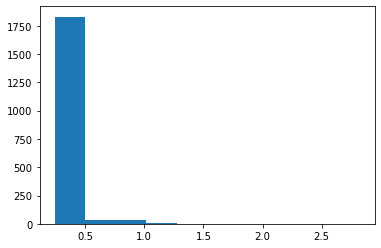

In [15]:
fig, ax = plt.subplots(1)

ax.hist(obs_mean_event_array)

In [ ]:
synth_filenames = glob.glob(PATH+"SGP_synth*")

ds = xr.open_dataset(synth_filenames[0])

rad = ds["F_solar"].values

rad[699][0]

In [ ]:
ds = xr.open_dataset(rad_data_filenames[0])
rad = ds["BestEstimate_down_short_hemisp"].values
rad_daysplit = np.split(rad, 92)

rad_daysplit_clean = []

for i in range (0,len(rad_daysplit)):
    tmp_rad = rad_daysplit[i]
    tmp_clean = getRemoveDefects(tmp_rad)
    rad_daysplit_clean.append(tmp_clean)

In [ ]:
daily_mean_array = []
daily_max_array = []
daily_min_array = []
daily_skew_array = []

for i in range(0, len(rad_daysplit_clean)):
    tmp_mean = np.mean(rad_daysplit_clean[i])
    tmp_max = np.amax(rad_daysplit_clean[i])
    tmp_min = np.amin(rad_daysplit_clean[i])
    tmp_skew = sts.skew(rad_daysplit_clean[i])
    daily_mean_array.append(tmp_mean)
    daily_max_array.append(tmp_max)
    daily_min_array.append(tmp_min)
    daily_skew_array.append(tmp_skew)

max_peak = np.amax(daily_max_array)
min_peak = np.amin(daily_max_array)

len(daily_mean_array)